In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load the crime data from the city of Buenos Aires of 2021

In [2]:
#load the buenos aires crime dataset of 2021
df = pd.read_csv('C:\\Users\\nicor\\OneDrive\\Documentos\\Python\\Datacamp\\ML fun ride\\buenos_aires_crime_2021.csv',sep=';')

### Data Exploration

In [3]:
#short EDA on the dataset
df.head()

,id-mapa,anio,mes,dia,fecha,franja,tipo,subtipo,uso_armas,barrio,comuna,latitud,longitud,cantidad
0,HC-2021-1008202,2021,Enero,Miércoles,06/01/2021,18,Homicidio,Siniestro Vial,NaN,Constitución,1.0,"-34,62761","-58,379146",1.0
1,HC-2021-1009094,2021,Enero,Jueves,07/01/2021,10,Homicidio,Siniestro Vial,NaN,Mataderos,9.0,"-34,64972969","-58,51058958",1.0
2,HC-2021-1013236,2021,Enero,Domingo,10/01/2021,7,Homicidio,Siniestro Vial,NaN,Parque Chacabuco,7.0,"-34,62917196","-58,43058079",1.0
3,HC-2021-1014154,2021,Enero,Lunes,11/01/2021,9,Homicidio,Siniestro Vial,NaN,Nueva Pompeya,5.0,"-34,63867577","-58,4145554",1.0
4,HC-2021-1015476,2021,Enero,Lunes,11/01/2021,21,Homicidio,Siniestro Vial,NaN,Parque Avellaneda,9.0,"-34,64771436","-58,46806552",1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88567 entries, 0 to 88566
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id-mapa    88567 non-null  object 
 1   anio       88567 non-null  int64  
 2   mes        88567 non-null  object 
 3   dia        88567 non-null  object 
 4   fecha      88567 non-null  object 
 5   franja     88567 non-null  object 
 6   tipo       88567 non-null  object 
 7   subtipo    16321 non-null  object 
 8   uso_armas  8472 non-null   object 
 9   barrio     87390 non-null  object 
 10  comuna     87907 non-null  float64
 11  latitud    88567 non-null  object 
 12  longitud   88567 non-null  object 
 13  cantidad   7299 non-null   float64
dtypes: float64(2), int64(1), object(11)
memory usage: 9.5+ MB


In [5]:
df.describe()

,anio,comuna,cantidad
count,88567.0,87907.000000,7299.000000
mean,2021.0,7.538899,1.158515
std,0.0,4.554293,0.557664
min,2021.0,0.000000,1.000000
25%,2021.0,4.000000,1.000000
50%,2021.0,7.000000,1.000000
75%,2021.0,12.000000,1.000000
max,2021.0,15.000000,10.000000


### dataset preparation

In [6]:
df.columns

Index(['id-mapa', 'anio', 'mes', 'dia', 'fecha', 'franja', 'tipo', 'subtipo',
       'uso_armas', 'barrio', 'comuna', 'latitud', 'longitud', 'cantidad'],
      dtype='object')

In [7]:
#convert the date column to datetime
df['date'] = pd.to_datetime(df['fecha'], dayfirst=True)

#encode the mes variable to a numerical variable
df['month_num'] = pd.to_datetime(df['fecha']).dt.month

#encode the dia variable to a numerical variable (1-7)
df['day_of_week'] = pd.to_datetime(df['fecha']).dt.dayofweek

#drop unnecesary columns
df.drop(columns=['id-mapa','anio','mes','dia','fecha','latitud','longitud'], inplace=True) 

In [8]:
#rename the columns
df.rename(columns={'tipo':'crime_type','franja':'time_span','subtipo':'crime_subtype',
'uso_armas':'weapon_use','barrio': 'district','comuna': 'neighborhood',
 'cantidad': 'quantity'}, inplace=True)

In [9]:
df_kmeans = df.copy(deep=True)

#deal with missing values
df_kmeans = df_kmeans[(df_kmeans['time_span'] != 'SD') &
                    (df_kmeans['time_span'] != 'sd') ].reset_index(drop=True)

#transform the time_span variable to a numerical variable
df_kmeans['time_span'] = df_kmeans['time_span'].astype(int)

#let's see the null values of the dataset
print('Missing values in the dataset:')
print(df_kmeans.isnull().sum())

#drop the quantity and crime_subtype columns as they have too many missing values
df_kmeans.drop(columns=['crime_subtype','quantity'], inplace=True) 

#drop the na values from district and neighborhood
df_kmeans.dropna(subset=['district','neighborhood'], inplace=True)

#assume that the missing values from the weapon_use column are that the person did not use any weapon
df_kmeans['weapon_use'] = df_kmeans['weapon_use'].fillna('No weapons used')

#see the shape of the dataset before and after the missing values treatment
print(f'\nThe quantity of rows before {df.shape[0]} and after {df_kmeans.shape[0]} the missing values treatment \n')

print('Missing values in the dataset:')
print(df_kmeans.isnull().sum())

Missing values in the dataset:
time_span            0
crime_type           0
crime_subtype    70801
weapon_use       78611
district          1110
neighborhood       593
quantity         79713
date                 0
month_num            0
day_of_week          0
dtype: int64

The quantity of rows before 88567 and after 85901 the missing values treatment 

Missing values in the dataset:
time_span       0
crime_type      0
weapon_use      0
district        0
neighborhood    0
date            0
month_num       0
day_of_week     0
dtype: int64


In [10]:
print('The crime_type column:')
print(df_kmeans.crime_type.unique())

#translate values of the crime_type column into english
df_kmeans['crime_type'] = df_kmeans['crime_type'].replace({'Homicidio':'Homicide',
                                                                'Lesiones':'Injury',
                                                                'Robo (con violencia)':'Theft (with violence)',
                                                                'Hurto (sin violencia)':'Petty Larceny'})

print('\nThe crime_type column after the translation')
print(df_kmeans.crime_type.unique())

print('\nThe weapon_use column:')
print(df_kmeans.weapon_use.unique())

#translate values of the weapon_use column into english
df_kmeans['weapon_use'] = df_kmeans['weapon_use'].replace({'Arma de fuego':'Firearm',
                                                            'Arma cortante': 'Stabbing weapon'})
print('\nThe weapon_use column after the translation')
print(df_kmeans.weapon_use.unique())

The crime_type column:
['Homicidio' 'Lesiones' 'Robo (con violencia)' 'Hurto (sin violencia)']

The crime_type column after the translation
['Homicide' 'Injury' 'Theft (with violence)' 'Petty Larceny']

The weapon_use column:
['No weapons used' 'Arma cortante' 'Arma de fuego']

The weapon_use column after the translation
['No weapons used' 'Stabbing weapon' 'Firearm']


In [11]:
df_kmeans.weapon_use.unique()

array(['No weapons used', 'Stabbing weapon', 'Firearm'], dtype=object)

##### Encoding categorical data

In [12]:
#Using sckit-learn's LabelEncoder for the barrio categorical feature
from sklearn.preprocessing import LabelEncoder

# Set up the LabelEncoder object
enc = LabelEncoder()

#Apply the encoding to the barrio feature
df_kmeans['district_enc'] = enc.fit_transform(df_kmeans['district'])

#Create a new encoded column with 0 to the no weapon used values, 1 to the stabbings and 2 to the firearms
df_kmeans['weapon_use_enc'] = df_kmeans['weapon_use'].map({'No weapons used':0,
                                                            'Stabbing weapon':1,
                                                            'Firearm':2})


In [13]:
#save the encoded categorical features
encoding_df = df_kmeans[['district', 'district_enc','weapon_use', 'weapon_use_enc']].drop_duplicates().reset_index(drop=True)

# Compare the two columns (sckit label encoder)
print('The two columns of barrio before and after the encoding')
print(df_kmeans[['district','district_enc']].drop_duplicates().reset_index(drop=True))
print('\n')
print('The two columns of uso_armas before and after the encoding')
print(df_kmeans[['weapon_use','weapon_use_enc']].drop_duplicates().reset_index(drop=True))

#drop the categorical features
df_kmeans.drop(columns=['district','weapon_use'], inplace=True)

The two columns of barrio before and after the encoding
             district  district_enc
0        Constitución            11
1           Mataderos            15
2    Parque Chacabuco            23
3       Nueva Pompeya            18
4   Parque Avellaneda            22
5             Palermo            21
6         Parque Chas            24
7           Caballito             7
8            Saavedra            30
9            Recoleta            28
10       Villa Lugano            39
11    Vélez Sársfield            48
12   Villa Del Parque            36
13          Agronomía             0
14           Barracas             3
15      Villa Urquiza            47
16            Almagro             1
17          Balvanera             2
18               Boca             5
19           Belgrano             4
20             Flores            12
21          Monserrat            16
22              Boedo             6
23   Parque Patricios            25
24      Villa Soldati            46
25      

In [14]:
df_kmeans.head(5)

,time_span,crime_type,neighborhood,date,month_num,day_of_week,district_enc,weapon_use_enc
0,18,Homicide,1.0,2021-01-06,6,1,11,0
1,10,Homicide,9.0,2021-01-07,7,3,15,0
2,7,Homicide,7.0,2021-01-10,10,4,23,0
3,9,Homicide,5.0,2021-01-11,11,0,18,0
4,21,Homicide,9.0,2021-01-11,11,0,22,0


In [15]:
df_kmeans.crime_type.value_counts()

Theft (with violence)    43794
Petty Larceny            35326
Injury                    6589
Homicide                   192
Name: crime_type, dtype: int64

C:\Users\nicor\anaconda3\envs\mne3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


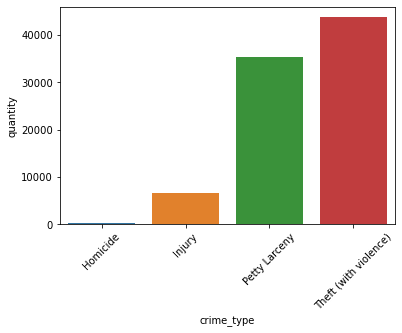

In [16]:
#see the quantity of each type of crime in the dataset
df_g = df_kmeans.groupby(['crime_type']).agg(quantity = pd.NamedAgg(column='crime_type', aggfunc='count')).reset_index()

#plot the quantity of each type of crime
fig, ax = plt.subplots() #1,figsize=(15,5))
sns.barplot(x='crime_type', y= 'quantity' , data=df_g )
plt.xticks(rotation=45)
fig.show()

### Assign numerical values to the crime_type variable according to the severity of the crime

In [17]:
#Create a dictionary with the severity to each crime type
severity_dict = {'Petty Larceny':0,
                 'Theft (with violence)':1,
                 'Injury':2,
                 'Homicide':3
}

#Assign the severity to each crime type
df_kmeans['severity'] = df_kmeans['crime_type'].map(severity_dict)

##### if the crime was commited using a weapon, the severity increses

In [18]:
#add to the severity column the severity of use of weapons
df_kmeans['severity'] = df_kmeans['severity'] + df_kmeans['weapon_use_enc']

#### Correlation between variables

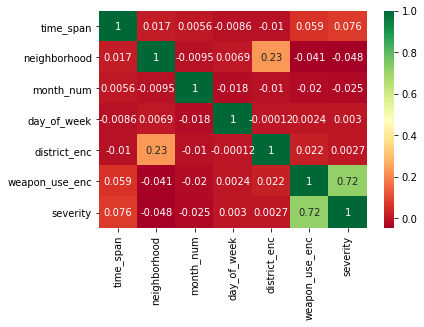

In [19]:
#Analyze correlation between variables
corr = df_kmeans.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True, cmap='RdYlGn')
plt.show()

### K-Means ###

In [20]:
# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

In [21]:
# Create arrays for the features and the response variable
x = df_kmeans.drop(['date','crime_type','severity'], axis=1).values
y = df_kmeans['severity'].values

#### Split the data into training and testing sets

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
#split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [24]:
#Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

In [25]:
#loop over different values of k

for i,k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(x_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(x_train, y_train)
    
    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(x_test, y_test)

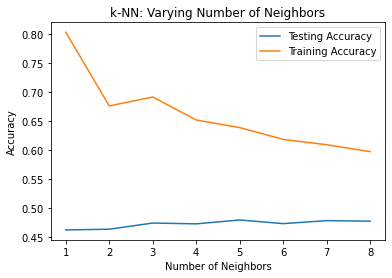

In [26]:
# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
#for index in range(len(neighbors)):
 # plt.text(neighbors[index], round(train_accuracy[index],2),round(train_accuracy[index],2), size = 12) #, y[index], size=12)
plt.show()

In [35]:
#get the max values from the train and test accuracies
max_train = train_accuracy.max()
max_test = test_accuracy.max()

print('The max value of train accuracy is: ' + str(max_train) + ' with the number of neighbors: ' + str(neighbors[train_accuracy.argmax()]))
print('The max value of test accuracy is: ' + str(max_test) + ' with the number of neighbors: ' + str(neighbors[test_accuracy.argmax()]))

The max value of train accuracy is: 0.8028812572759022 with the number of neighbors: 1
The max value of test accuracy is: 0.48000698445957746 with the number of neighbors: 5


Conclusion:
- The best k to select end up to be 5 as it had the highest accuracy in the training and test sets

In [38]:
# Create a k-NN classifier with 5 neighbors
knn = KNeighborsClassifier(n_neighbors = 5)

In [39]:
# Fit the classifier to the data
knn.fit(x_train,y_train)

KNeighborsClassifier()

In [40]:
#convert the x_test array into a pandas dataframe
test_df = pd.DataFrame(x_test, columns=['time_span','neighborhood','month_num',
'day_of_week','district_enc','weapon_use_enc'])

In [41]:
#predictions
prediction = knn.predict(x_test)

#convert the prediction array into a pandas dataframe and add the y_test column
prediction_df = pd.DataFrame(prediction, columns=['prediction'])
prediction_df['y_test'] = y_test

In [57]:
#see how many predictions are correct
print('The number of correct predictions is: '+ str(prediction_df[prediction_df['prediction'] == prediction_df['y_test']].shape[0]))

#see how many predictions are incorrect
print('The number of incorrect predictions is: ' + str(prediction_df[prediction_df['prediction'] != prediction_df['y_test']].shape[0]))

acc = prediction_df[prediction_df['prediction'] == prediction_df['y_test']].shape[0]/prediction_df.shape[0]
#see the percentage of correct predictions
print('In conclusion, the percentage of correct predictions is: ' + str(round(acc,4)*100) + '%')

The number of correct predictions is: 8247
The number of incorrect predictions is: 8934
In conclusion, the percentage of correct predictions is: 48.0%


In [58]:
#concatenate the test dataframe with the prediction dataframe
test_df = pd.concat([test_df, prediction_df], axis=1)